In [1]:
import pickle
from matplotlib import font_manager, rc

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
with open('datas/kaida.pkl', 'rb') as f:
    kaida_df = pickle.load(f)

In [5]:
kaida_df['sales_type'] = kaida_df['sales_type'].apply(lambda x: x.strip()) # 공백제거
kaida_df.drop(index=kaida_df[kaida_df['model'].str.contains('Total')].index, inplace=True) # Total 제거
kaida_df.drop_duplicates(inplace=True) # 중복된 row 제거
kaida_df['month'] = kaida_df['month'].apply(lambda x: x[:-1]) # '월' 제거
kaida_df['value'] = kaida_df['value'].apply(lambda x: x.replace(",", "")) # , 제거
kaida_df.reset_index(drop=True, inplace=True) # index 정리

kaida_df['date'] = kaida_df['year'].astype('str') + "-" + kaida_df['month'] # date column 생성
kaida_df['date'] = pd.to_datetime(kaida_df['date'], format="%Y-%m", errors='raise') # datetime으로 전환
kaida_df['date'] = kaida_df['date'].dt.strftime("%Y-%m") # 년-월만 출력

kaida_df = kaida_df.astype({col: "int" for col in ['value', 'month', 'year']}) # 정수로 데이터타입 변환

In [6]:
print(kaida_df.shape)
kaida_df.head(2)

(240048, 8)


,brand,model,value,sales_type,age,month,year,date
0,BMW,218dGranCoupe,0,개인-남자,~19,1,2021,2021-01
1,BMW,520,1,개인-남자,~19,1,2021,2021-01


In [7]:
kaida_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240048 entries, 0 to 240047
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   brand       240048 non-null  object
 1   model       240048 non-null  object
 2   value       240048 non-null  int64 
 3   sales_type  240048 non-null  object
 4   age         240048 non-null  object
 5   month       240048 non-null  int64 
 6   year        240048 non-null  int64 
 7   date        240048 non-null  object
dtypes: int64(3), object(5)
memory usage: 14.7+ MB


In [9]:
target_brand = "Mercedes-Benz" # 타켓 브랜드 지정

In [17]:
z_chart_df = kaida_df.groupby(['brand', 'date']).agg('sum')['value'].reset_index() # 기간별 브랜드간의 등록대수 dataframe
z_chart_df = z_chart_df[z_chart_df['brand'] == target_brand].sort_values('date') # 벤츠만 targeting
z_chart_df = z_chart_df[z_chart_df['date'] < "2021-05"].reset_index(drop=True) # 2021.5 이전 데이터만 리턴

z_chart_df2 = z_chart_df.tail(12).reset_index(drop=True) # 벤츠의 최근 12개월 등록대수 dataframe

In [19]:
# 매출누계 data 생성하는 코드
ls = []
prev = 0
for value in z_chart_df2['value'].values:
    curr = prev + value
    prev = curr
    ls.append(curr)
    
# 이동년계 data 생성하는 코드
ls_2 = []
for num in range(z_chart_df.shape[0] - 11, z_chart_df.shape[0] + 1):
    idx = num - 12
    ls_2.append(z_chart_df['value'].values[idx:num].sum())

In [20]:
z_chart_df2['매출누계'] = ls
z_chart_df2['이동년계'] = ls_2

In [23]:
z_chart_df2

,brand,date,value,매출누계,이동년계
0,Mercedes-Benz,2020-05,2523,2523,32448
1,Mercedes-Benz,2020-06,3774,6297,32839
2,Mercedes-Benz,2020-07,2247,8544,31765
3,Mercedes-Benz,2020-08,2631,11175,31988
4,Mercedes-Benz,2020-09,2713,13888,32338
5,Mercedes-Benz,2020-10,3038,16926,32146
6,Mercedes-Benz,2020-11,2527,19453,31494
7,Mercedes-Benz,2020-12,2892,22345,29880
8,Mercedes-Benz,2021-01,3427,25772,31328
9,Mercedes-Benz,2021-02,2910,28682,32608


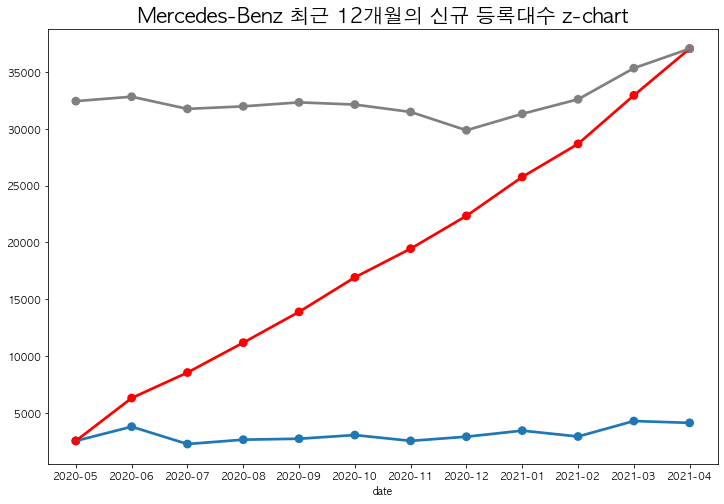

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

sns.pointplot(data=z_chart_df2, x='date', y='value', ax=ax)
sns.pointplot(data=z_chart_df2, x='date', y='매출누계', ax=ax, color='r')
sns.pointplot(data=z_chart_df2, x='date', y='이동년계', ax=ax, color='gray')

plt.title(f"{target_brand} 최근 12개월의 신규 등록대수 z-chart", fontsize=20)
plt.ylabel(None)

plt.show()

#### 일련의 과정 함수화
- brand : targeting할 브랜드 (str)
- data : targeting할 날짜 (str)

In [73]:
def make_z_chart(brand, date):
    z_chart_df = kaida_df.groupby(['brand', 'date']).agg('sum')['value'].reset_index()
    z_chart_df = z_chart_df[z_chart_df['brand'] == brand]
    z_chart_df = z_chart_df[z_chart_df['date'] < date]
    
    z_chart_df2 = z_chart_df.tail(12).reset_index(drop=True)
    
    ls = []
    prev = 0
    for value in z_chart_df2['value'].values:
        curr = prev + value
        prev = curr
        ls.append(curr)
    
    z_chart_df2['매출누계'] = ls
    
    ls_2 = []
    for num in range(z_chart_df.shape[0] - 11, z_chart_df.shape[0] + 1):
        idx = num - 12
        ls_2.append(z_chart_df['value'].values[idx:num].sum())
        
    z_chart_df2['이동년계'] = ls_2
    
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    sns.pointplot(data=z_chart_df2, x='date', y='value', ax=ax)
    sns.pointplot(data=z_chart_df2, x='date', y='매출누계', ax=ax, color='r')
    sns.pointplot(data=z_chart_df2, x='date', y='이동년계', ax=ax, color='gray')

    plt.title(f"{brand} 최근 12개월의 신규 등록대수 z-chart", fontsize=20)
    plt.ylabel(None)

    plt.show()

[535, 1245, 1764, 2075, 2567, 2951, 3516, 4190, 10861, 17475, 24832, 32402]


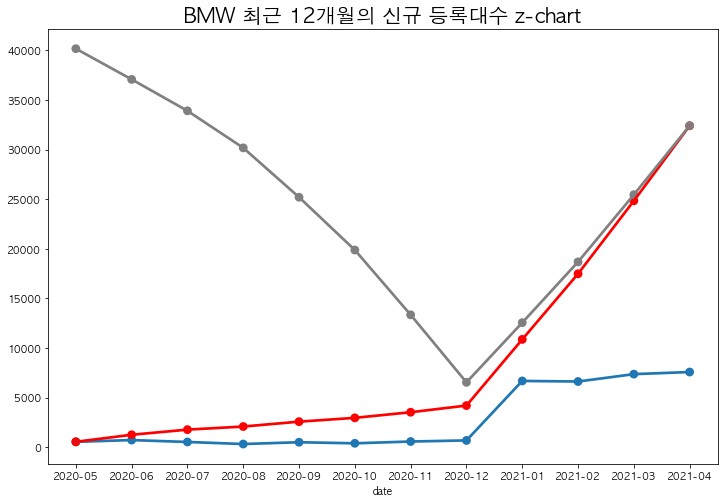

In [72]:
make_z_chart("BMW", "2021-05")